<h1><center><b>Topic modeling (a simple exercise)</b></center></h1>
<h3><center><b>Authors</b></center></h3>
<p><center>Adrián Rubén Bedón Campaña</center></p>
<p><center>Pablo Alejandro Chasipanta Silva</center></p>
<p><center>José Miguel Merlo Santacruz</center></p>
<p><center>Dennis Steven Ocaña Santamaría</center></p>
<p><center>Xavier Alejandro Ramos Vásconez</center></p>

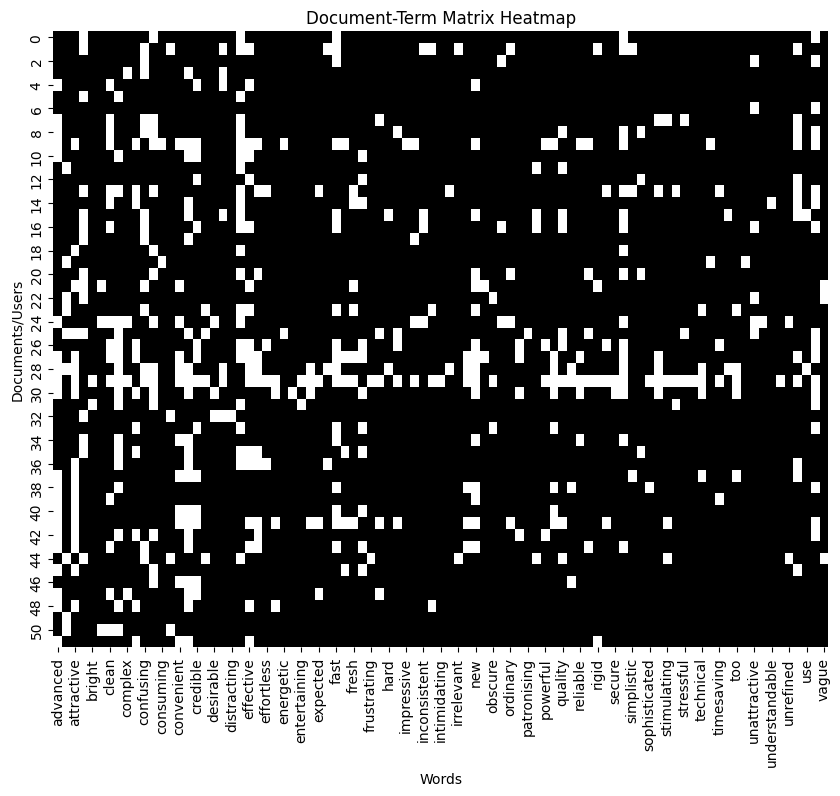

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import community as community_louvain

# Import the CSV file into a pandas DataFrame
url = "https://raw.githubusercontent.com/marsgr6/estadistica-ux/main/data/words_ux.csv"
df = pd.read_csv(url)

# Combine words in each row into a single document
df['document'] = df['Words'].apply(lambda x: ' '.join(x.split(',')))

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the documents and transform them into a document-term matrix
dtm = vectorizer.fit_transform(df['document'])

# Convert the document-term matrix to a pandas DataFrame
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(dtm_df, cmap="gray", annot=False, cbar=False)  # Updated cmap and cbar
plt.title("Document-Term Matrix Heatmap")
plt.xlabel("Words")
plt.ylabel("Documents/Users")
plt.show()

## Jaccard Similarity

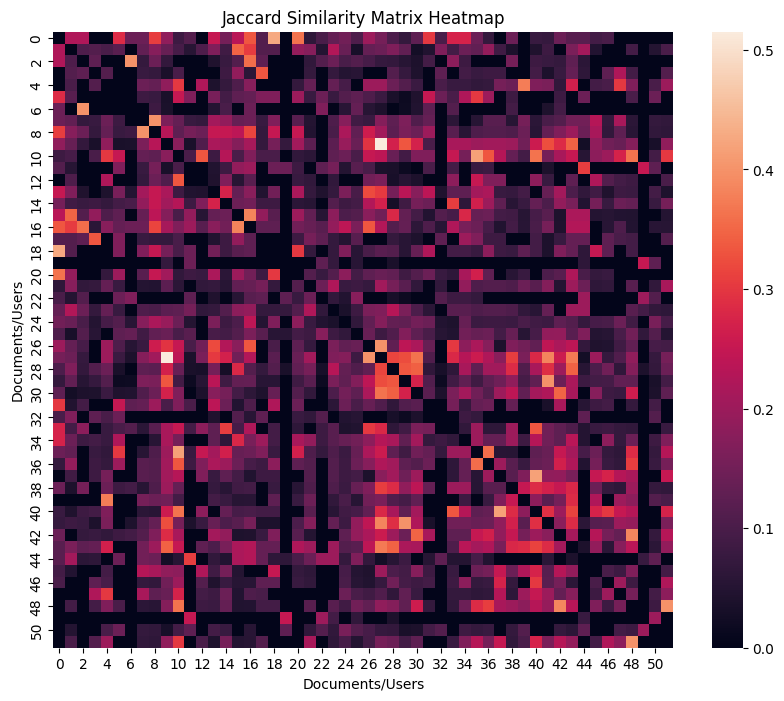

In [2]:
# Calculate Jaccard similarity matrix
num_docs = dtm_df.shape[0]
jaccard_matrix = np.zeros((num_docs, num_docs))

for i in range(num_docs):
    for j in range(i + 1, num_docs):
        jaccard_matrix[i, j] = jaccard_score(dtm_df.iloc[i], dtm_df.iloc[j], average='binary')  # average='binary' for presence/absence
        jaccard_matrix[j, i] = jaccard_matrix[i, j]  # Ensure symmetry

# Visualize similarity matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, annot=False)  # Set annot=False
plt.title("Jaccard Similarity Matrix Heatmap")
plt.xlabel("Documents/Users")
plt.ylabel("Documents/Users")
plt.show()

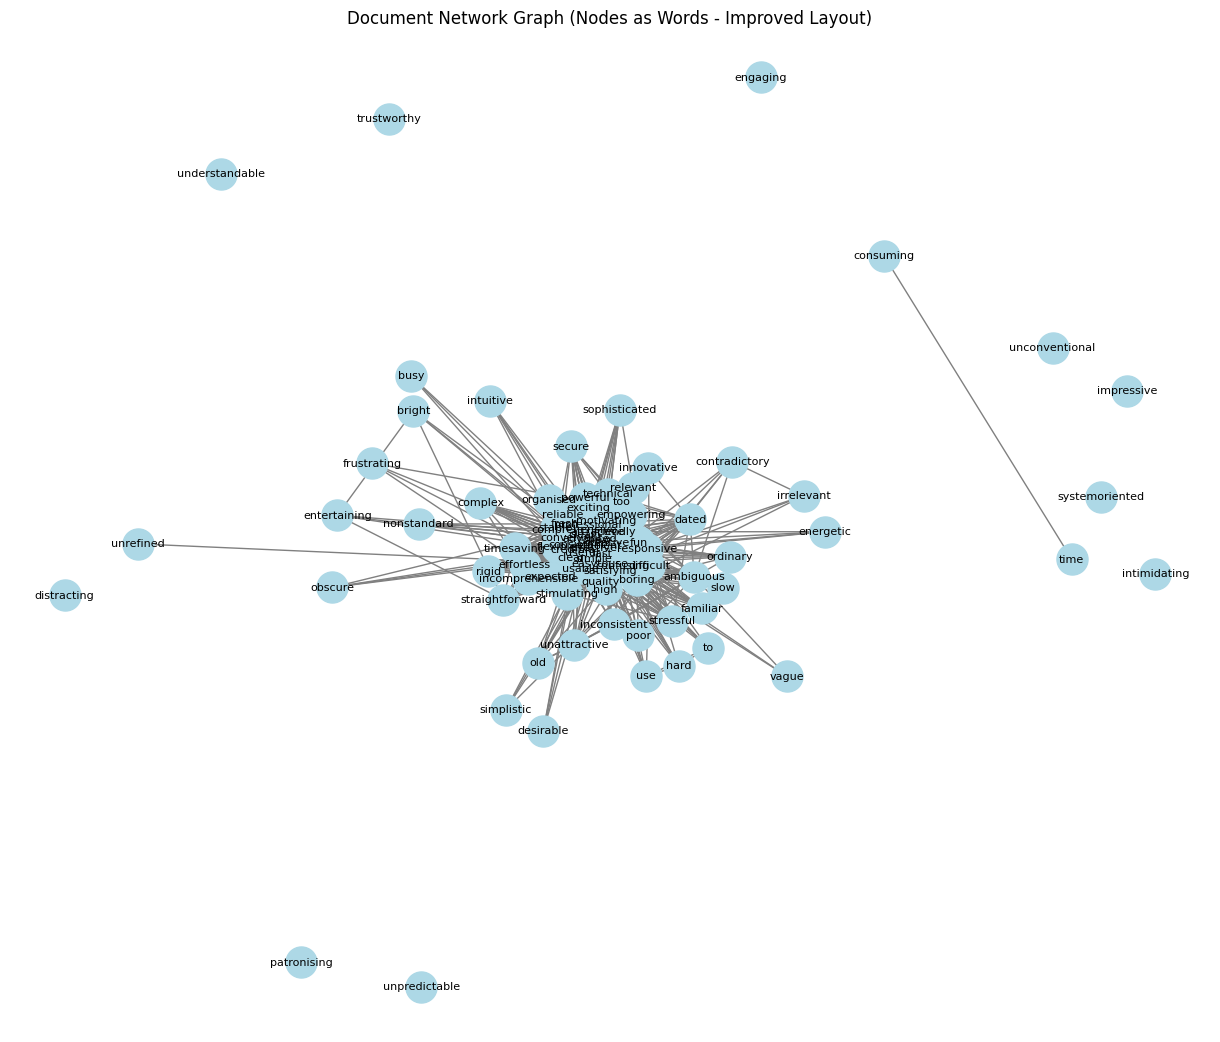

In [3]:
# Create a graph object
graph = nx.Graph()

# Add nodes (words) to the graph
words = vectorizer.get_feature_names_out()  # Get unique words from the vectorizer
graph.add_nodes_from(words)

# Add edges based on similarity matrix
num_docs = jaccard_matrix.shape[0]
for i in range(num_docs):
    for j in range(i + 1, num_docs):
        if jaccard_matrix[i, j] > 0:  # Connect if similarity is greater than 0
            # Get the words present in both documents
            common_words = [word for word in words if dtm_df.iloc[i][word] > 0 and dtm_df.iloc[j][word] > 0]
            
            # Add edges between common words with weight as Jaccard similarity
            for word1 in common_words:
                for word2 in common_words:
                    if word1 != word2:
                        if graph.has_edge(word1, word2):
                            # Increase weight if edge already exists
                            graph[word1][word2]['weight'] += jaccard_matrix[i, j]
                        else:
                            # Add edge with weight
                            graph.add_edge(word1, word2, weight=jaccard_matrix[i, j])

# Visualize the graph with improved layout
plt.figure(figsize=(12, 10))

# Choose a better layout algorithm
pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=42)  # Adjust k, iterations, seed for better spacing

# Draw the graph
nx.draw(graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=8, node_size=500)
plt.title("Document Network Graph (Nodes as Words - Improved Layout)")
plt.show()

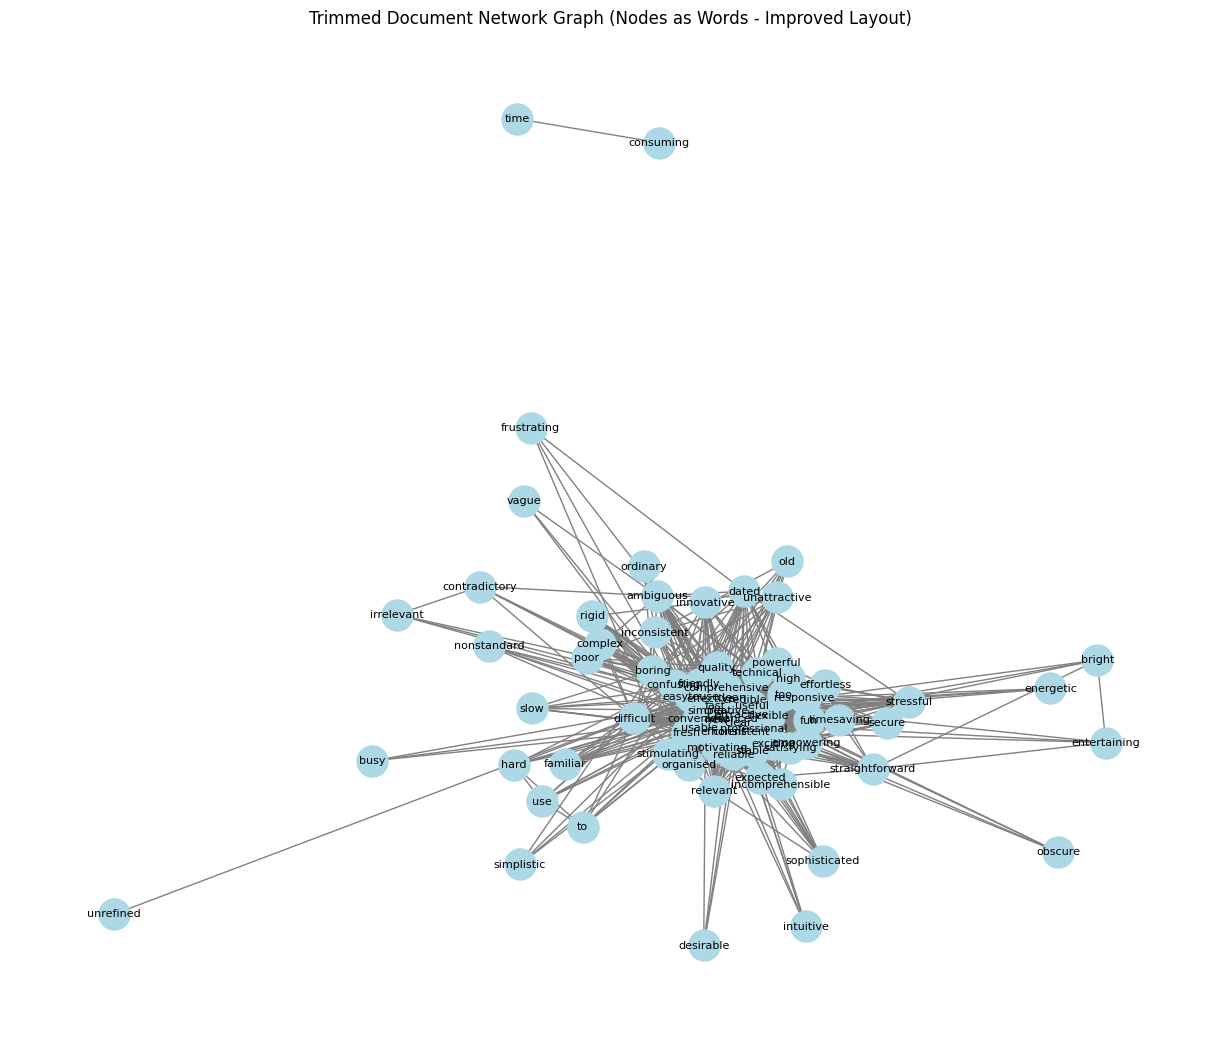

In [4]:
# Calculate edge weights and determine threshold
edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
threshold = np.percentile(edge_weights, 0)  # Adjust percentile as needed

# Remove edges below the threshold
edges_to_remove = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] < threshold]
graph.remove_edges_from(edges_to_remove)
# Remove unconnected nodes
graph.remove_nodes_from(list(nx.isolates(graph)))

# Visualize the trimmed graph with improved layout and removed unconnected nodes
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=42)  # Adjust layout parameters
nx.draw(graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=8, node_size=500)
plt.title("Trimmed Document Network Graph (Nodes as Words - Improved Layout)")
plt.show()

Community 0: advanced, attractive, convenient, creative, credible, effective, efficient, energetic, fast, flexible, incomprehensible, motivating, new, nonstandard, obscure, professional, relevant, reliable, responsive, sophisticated
Community 4: ambiguous, boring, clean, complex, confusing, consistent, contradictory, dated, desirable, difficult, easytouse, familiar, frustrating, hard, inconsistent, innovative, irrelevant, old, ordinary, poor, quality, rigid, simple, simplistic, slow, to, unattractive, unrefined, usable, use, vague
Community 1: bright, busy, clear, comprehensive, effortless, entertaining, friendly, organised, powerful, straightforward, timesaving, useful
Community 3: consuming, time
Community 2: empowering, exciting, expected, fresh, fun, high, intuitive, satisfying, secure, stable, stimulating, stressful, technical, too


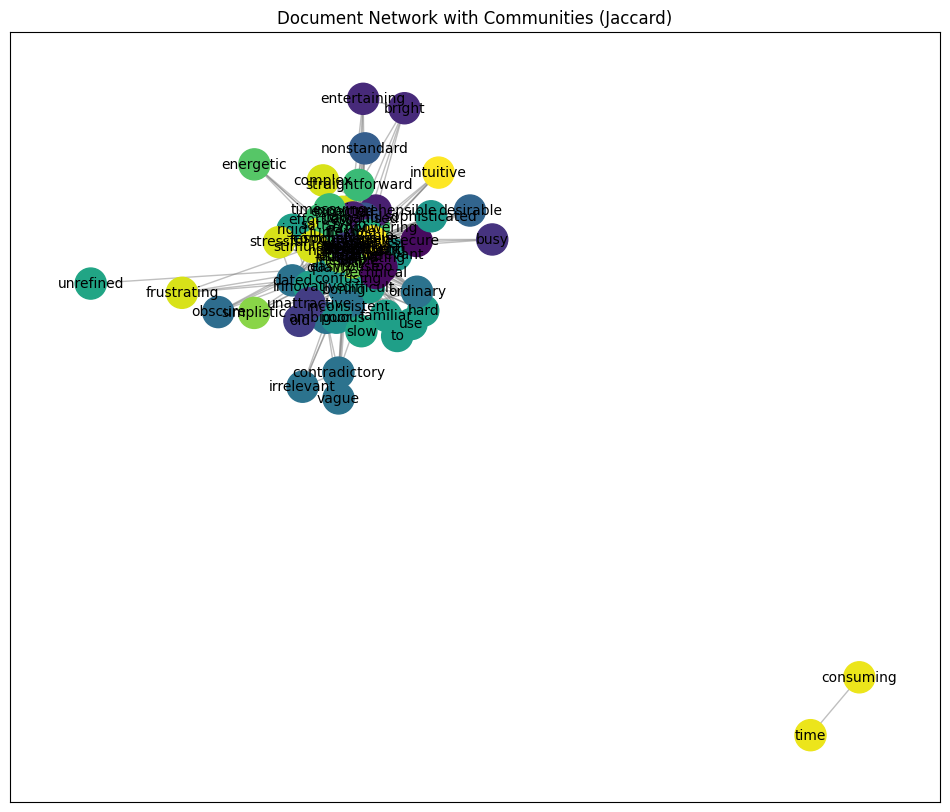

In [5]:
# Apply Louvain Modularity algorithm
resolution = 5.0  # Adjust this value to control community size
partition = community_louvain.best_partition(graph, resolution=resolution)

# Get community colors
community_colors = [partition[node] for node in graph.nodes()]

# Visualize the graph with communities using a better layout
plt.figure(figsize=(12, 10)) 
pos = nx.spring_layout(graph)

# Draw nodes and edges
nx.draw_networkx_nodes(graph, pos, node_color=community_colors, cmap="viridis", node_size=500)
nx.draw_networkx_edges(graph, pos, edge_color="gray", alpha=0.5)  # Adjust alpha for edge visibility
nx.draw_networkx_labels(graph, pos, font_size=10)

# Apply Louvain Modularity algorithm
partition = community_louvain.best_partition(graph)

# Print community structure in desired format
community_words = {}  # Dictionary to store words for each community
for node, community_id in partition.items():
    if community_id not in community_words:
        community_words[community_id] = []
    community_words[community_id].append(node)

for community_id, words in community_words.items():
    print(f"Community {community_id}: {', '.join(words)}")

plt.title("Document Network with Communities (Jaccard)")
plt.show()

## Euclidian Distance

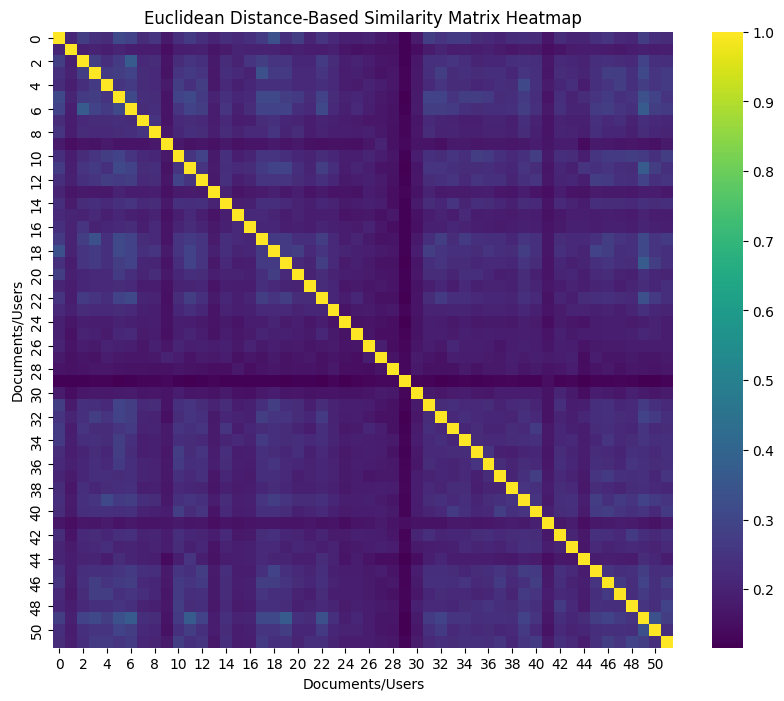

In [6]:
# Calculate Euclidean distance matrix
euclidean_matrix = euclidean_distances(dtm_df)

# Convert to similarity matrix
similarity_matrix = 1 / (1 + euclidean_matrix)

# Convert to DataFrame (optional)
similarity_df = pd.DataFrame(similarity_matrix, index=dtm_df.index, columns=dtm_df.index)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(similarity_df, annot=False, cmap="viridis")  # You can change the colormap
plt.title("Euclidean Distance-Based Similarity Matrix Heatmap")
plt.xlabel("Documents/Users")
plt.ylabel("Documents/Users")
plt.show()

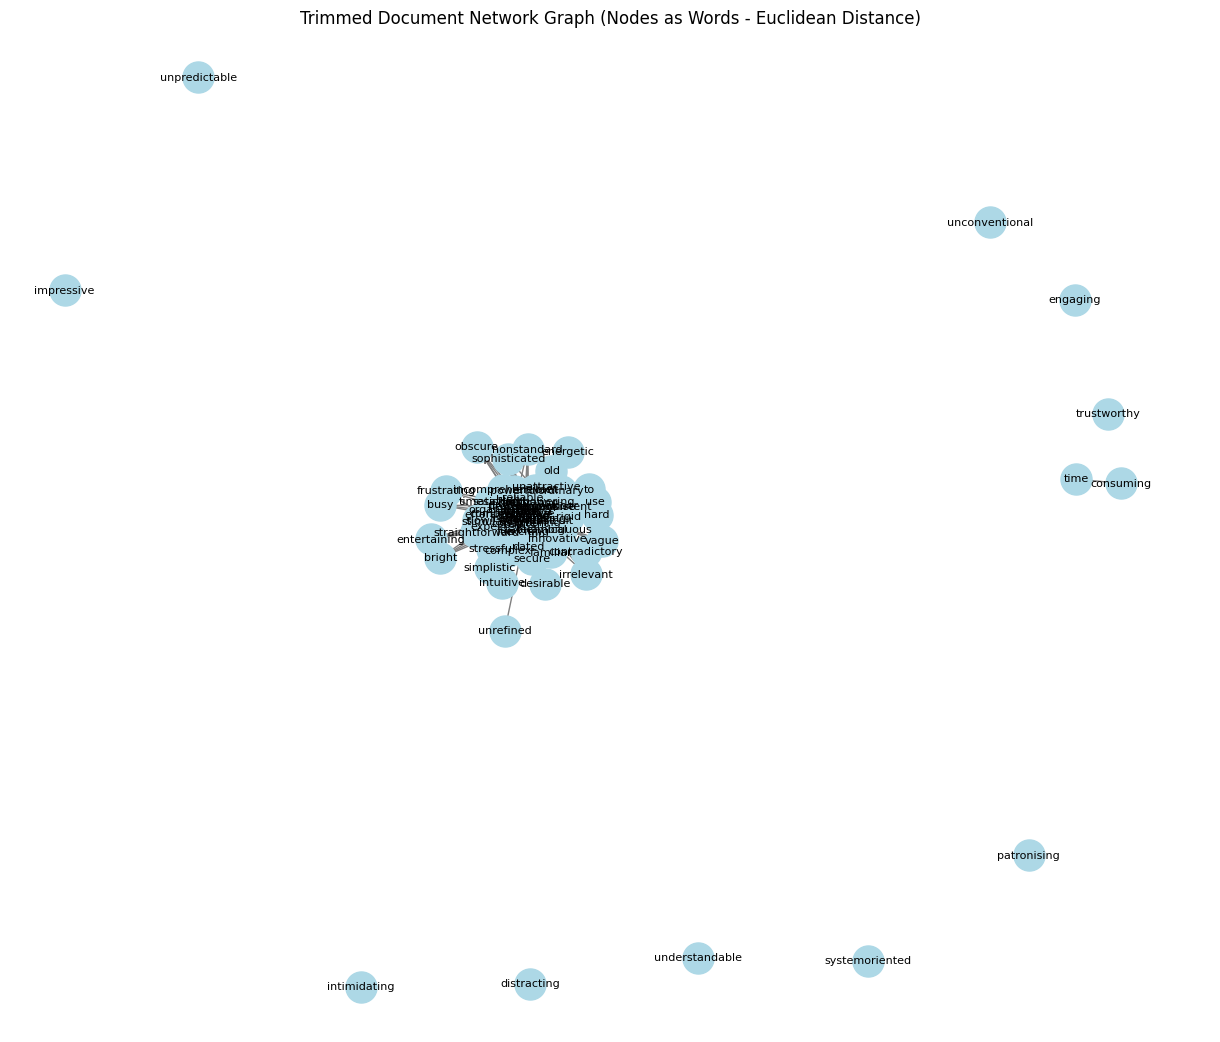

In [7]:
# Create a graph object
graph = nx.Graph()

# Add nodes (words) to the graph
words = vectorizer.get_feature_names_out()  # Get unique words from the vectorizer
graph.add_nodes_from(words)

# Add edges based on similarity matrix
num_docs = similarity_matrix.shape[0]  # Use similarity_matrix instead of jaccard_matrix
for i in range(num_docs):
    for j in range(i + 1, num_docs):
        if similarity_matrix[i, j] > 0:  # Connect if similarity is greater than 0
            # Get the words present in both documents
            common_words = [word for word in words if dtm_df.iloc[i][word] > 0 and dtm_df.iloc[j][word] > 0]
            
            # Add edges between common words with weight as Euclidean similarity
            for word1 in common_words:
                for word2 in common_words:
                    if word1 != word2:
                        if graph.has_edge(word1, word2):
                            # Increase weight if edge already exists
                            graph[word1][word2]['weight'] += similarity_matrix[i, j]
                        else:
                            # Add edge with weight
                            graph.add_edge(word1, word2, weight=similarity_matrix[i, j])

# Visualize the graph (you can adjust layout and visualization parameters as before)
edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
threshold = np.percentile(edge_weights, 0)  # Adjust percentile as needed

# Remove edges below the threshold
edges_to_remove = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] < threshold]
graph.remove_edges_from(edges_to_remove)

# Visualize the trimmed graph (you can adjust layout and visualization parameters as before)
plt.figure(figsize=(12, 10))
nx.draw(graph, with_labels=True, node_color="lightblue", edge_color="gray", font_size=8, node_size=500)
plt.title("Trimmed Document Network Graph (Nodes as Words - Euclidean Distance)")
plt.show()

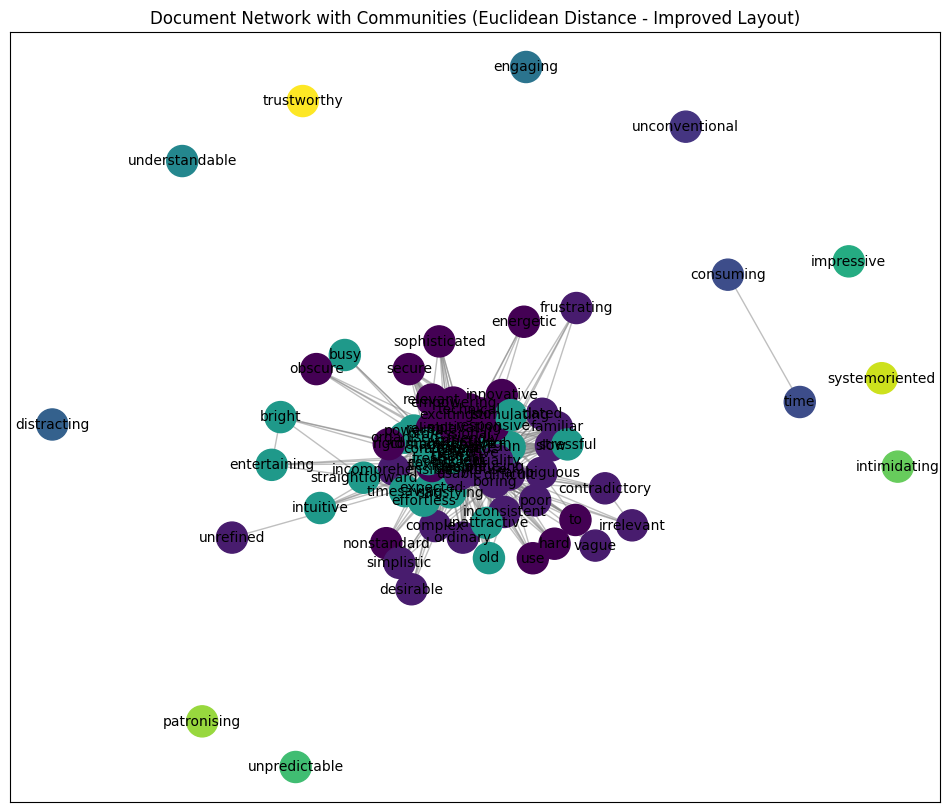

Community 0: advanced, attractive, convenient, creative, credible, effective, efficient, empowering, energetic, exciting, fast, flexible, friendly, hard, innovative, motivating, new, nonstandard, obscure, professional, relevant, reliable, responsive, rigid, secure, sophisticated, technical, to, too, use
Community 1: ambiguous, boring, clean, complex, confusing, consistent, contradictory, dated, desirable, difficult, easytouse, familiar, frustrating, incomprehensible, inconsistent, irrelevant, ordinary, poor, quality, simple, simplistic, slow, unrefined, usable, vague
Community 7: bright, busy, clear, comprehensive, effortless, entertaining, expected, fresh, fun, high, intuitive, old, organised, powerful, satisfying, stable, stimulating, straightforward, stressful, timesaving, unattractive, useful
Community 3: consuming, time
Community 4: distracting
Community 5: engaging
Community 8: impressive
Community 10: intimidating
Community 11: patronising
Community 12: systemoriented
Community 

In [8]:
# Apply Louvain Modularity algorithm
partition = community_louvain.best_partition(graph)

# Get community colors
community_colors = [partition[node] for node in graph.nodes()]

# Visualize the graph with communities using a better layout
plt.figure(figsize=(12, 10))  # Increase figure size for more space

# Choose a layout algorithm
# pos = nx.spring_layout(graph, k=1.0, iterations=200, seed=42)  # Adjust k, iterations, seed
# pos = nx.kamada_kawai_layout(graph, scale=3.0)  # Adjust scale for spacing
pos = nx.fruchterman_reingold_layout(graph, k=1.0, iterations=200, seed=42)  # Try this

# Draw nodes and edges
nx.draw_networkx_nodes(graph, pos, node_color=community_colors, cmap="viridis", node_size=500)
nx.draw_networkx_edges(graph, pos, edge_color="gray", alpha=0.5)  # Adjust alpha for edge visibility
nx.draw_networkx_labels(graph, pos, font_size=10)

plt.title("Document Network with Communities (Euclidean Distance - Improved Layout)")
plt.show()

# Print community structure
community_words = {}  # Dictionary to store words for each community
for node, community_id in partition.items():
    if community_id not in community_words:
        community_words[community_id] = []
    community_words[community_id].append(node)

for community_id, words in community_words.items():
    print(f"Community {community_id}: {', '.join(words)}")